In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from A3C import A3C
import os
from collections import defaultdict
from run_session import run_session
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import f_oneway

load = True
device = 0
np.random.seed(12345)
torch.random.manual_seed(12345)

## Maybe add in pseudo-random left/right later?

In [2]:
class lever():
    def __init__(self, FR_limit, PR_reward):
        super().__init__()
        self.num_presses = 2000 # perhaps this number needs to be changed
        self.mode = "PR"
        self.limits = {"PR":2, "FR":FR_limit}
        self.rewards = {"PR":PR_reward, "FR":1}
        self.progress = 0
    def pull(self, choice):
        modes = ["PR", "FR"]
        if modes[choice] == self.mode:
            self.progress += 1
        else:
            self.progress = 1
            self.mode = modes[choice]
        if self.progress > self.limits[modes[choice]]:
            print("error: progress shouldn't be greater than limit")
        if self.progress ==  self.limits[modes[choice]]:
            if modes[choice] == "PR":
                self.limits["PR"] += 1
            self.progress = 0
            return self.rewards[modes[choice]]
        return 0
    
def count_trials(actions, rewards, activ_hist): # activ_hist can be swapped out by value
    """
    action tags:
        0: PR
        1: FR
    trial tags:
        0: PR
        1: FR
        2: incomplete
    Returns:
        trials: actions grouped by trial
        trial_tags: type of trials
        trial_activ: activation grouped by trial
    """
    trials = []
    trial_tags = []
    trial_activ = []
    current_trial = []
    current_trial_activ = []
    for action, reward, activ in zip(actions, rewards, activ_hist):
        if current_trial == []: # start new trial
            current_trial.append(action)
            current_trial_activ.append(activ)
        else:
            if current_trial[-1] != action: # previous trial incomplete, initialize new trial
                trials.append(current_trial)
                trial_activ.append(current_trial_activ)
                trial_tags.append(2)
                current_trial = [action]
                current_trial_activ = [activ]
            elif reward > 0: # if current_trial[-1] == action and reward > 0, complete trial
                current_trial.append(action)
                current_trial_activ.append(activ)
                trials.append(current_trial)
                trial_activ.append(current_trial_activ)
                trial_tags.append(action)
                current_trial = []
                current_trial_activ = []
            else:
                current_trial.append(action) # if current_trial[-1] == action and reward = 0, continue trial
                current_trial_activ.append(activ)
    return trials, trial_tags, trial_activ

agent = A3C().cuda(device)
optimizer = torch.optim.RMSprop(agent.parameters(), 0.0007)

In [3]:
# train or load
if load and os.path.exists('models/PRvsFR.pth'):
    agent.load_state_dict(torch.load('models/PRvsFR.pth'))
else:
    for session_num in range(20000):
        FR_limit = [6, 12][np.random.choice(2)]
        PR_reward = [2, 5][np.random.choice(2)]
        experiment = lever(FR_limit, PR_reward)
        run_session(experiment, agent, optimizer, session_num, be = 0.075)
    torch.save(agent.state_dict(), "models/PRvsFR.pth")

In [4]:
d = defaultdict(list) # dictionary with key being experiment setup and value being all experiments under such setup
for session_num in range(25):
    for FR_limit in [6, 12]:
        for PR_reward in [2, 5]:
            experiment = lever(FR_limit, PR_reward)
            actions, rewards, value_preds = run_session(experiment, agent, optimizer, session_num, train = False)
            d[(FR_limit, PR_reward)].append((actions, rewards, value_preds, agent.activ_hist))

session: 0 reward: 0.1655
session: 0 reward: 0.1815
session: 0 reward: 0.0755
session: 0 reward: 0.107
session: 1 reward: 0.167
session: 1 reward: 0.187
session: 1 reward: 0.0765
session: 1 reward: 0.118
session: 2 reward: 0.166
session: 2 reward: 0.1835
session: 2 reward: 0.072
session: 2 reward: 0.106
session: 3 reward: 0.1665
session: 3 reward: 0.182
session: 3 reward: 0.0765
session: 3 reward: 0.113
session: 4 reward: 0.167
session: 4 reward: 0.1875
session: 4 reward: 0.076
session: 4 reward: 0.1145
session: 5 reward: 0.1665
session: 5 reward: 0.187
session: 5 reward: 0.0735
session: 5 reward: 0.112
session: 6 reward: 0.1665
session: 6 reward: 0.1855
session: 6 reward: 0.076
session: 6 reward: 0.113
session: 7 reward: 0.166
session: 7 reward: 0.1835
session: 7 reward: 0.0775
session: 7 reward: 0.1195
session: 8 reward: 0.1665
session: 8 reward: 0.1825
session: 8 reward: 0.0715
session: 8 reward: 0.1225
session: 9 reward: 0.1655
session: 9 reward: 0.1815
session: 9 reward: 0.0745
se

##  From original paper: "The estimated optimal numbers of trials at the PR side (𝑁_𝑃𝑅∗) are 10, 22, 28, and 58 trials at 2xFR6, 2xFR12, 5xFR6, and 5xFR12 respectively" <br> "The application of this analysis to our dataset revealed that indeed an effect of sunk cost existed. Surprisingly, it is not present in all four conditions of the task. A twoway ANOVA collapsing across sunk cost conditions revealed that the effect was only significant in contexts with a higher cost or benefit parameter"

In [5]:
optimal_switch = {(6, 2):10, (12, 2):22, (6, 5):28, (12, 5):58}

## Visualize

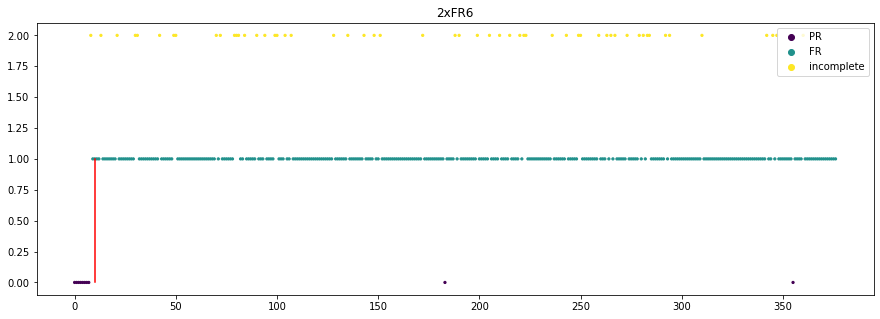

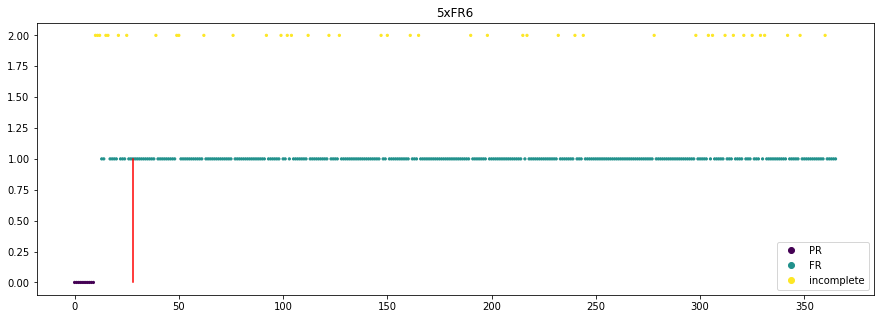

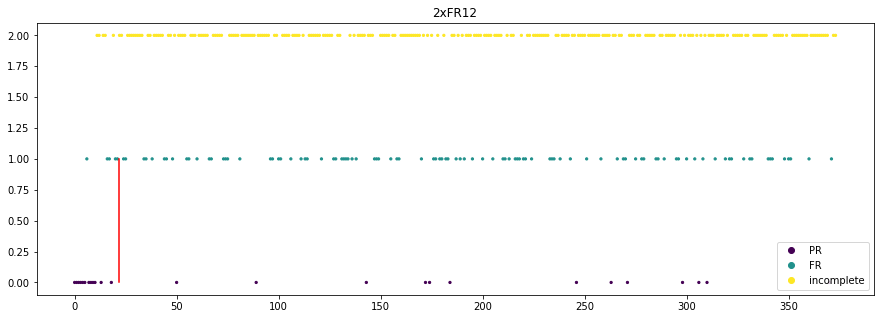

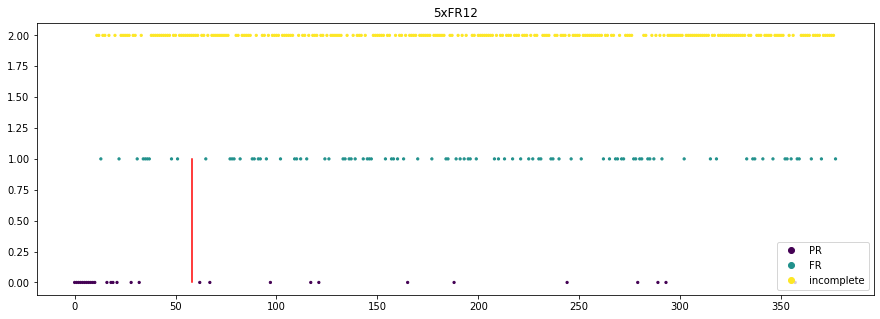

In [6]:
for (FR_limit, PR_reward), sessions in d.items():
    example_actions, example_rewards, example_value_preds, example_activ_hist = sessions[np.random.randint(len(sessions))]
    trials, trial_tags, trial_activ = count_trials(example_actions, example_rewards, example_activ_hist)
    plt.figure(figsize = (15, 5))
    scatter = plt.scatter(np.arange(len(trial_tags)), trial_tags, s = 5, c = trial_tags)
    plt.legend(handles=scatter.legend_elements()[0], labels=['PR', 'FR', 'incomplete'])
    plt.title('%dxFR%d'%(PR_reward, FR_limit))
    # add optimal line
    switch_time = optimal_switch[(FR_limit, PR_reward)]
    plt.plot([switch_time, switch_time], [0, 1], color='red')

## Analyze the contrast between exploration and exploitation trials
### We define exploration as incomplete trials, exploitation as complete trials

Text(0, 0.5, 'F-score')

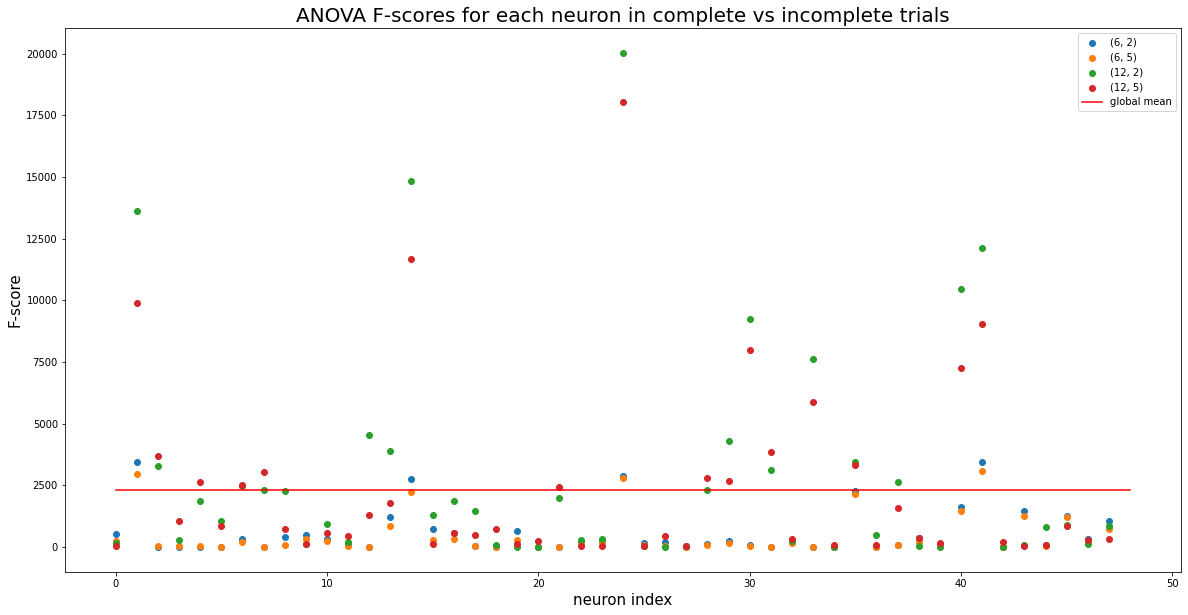

In [7]:
plt.figure(figsize=(20, 10))
plots = []
exploration_activs = {} # key: param value: neuron history
exploitation_activs = {}
for (FR_limit, PR_reward), sessions in d.items(): # for each parameter setting
    exploration_activ, exploitation_activ = [], []
    for (actions, rewards, value_preds, activ_hist) in sessions: # for each session under a setting
        trials, trial_tags, trial_activ = count_trials(actions, rewards, activ_hist)
        exploration_activ += ([trial_activ[i] for i in range(len(trial_tags)) if trial_tags[i] == 2])
        exploitation_activ += ([trial_activ[i] for i in range(len(trial_tags)) if trial_tags[i] != 2])
    exploration_activ = np.concatenate(exploration_activ)
    exploration_activs[(FR_limit, PR_reward)] = exploration_activ
    exploitation_activ = np.concatenate(exploitation_activ)
    exploitation_activs[(FR_limit, PR_reward)] = exploitation_activ
    f_score, p_value = f_oneway(exploration_activ, exploitation_activ)
    plots.append(plt.scatter(np.arange(len(f_score)), f_score))
plt.title('ANOVA F-scores for each neuron in complete vs incomplete trials', fontsize=20)
plots.append(plt.plot([0, len(f_score)], [f_score.mean(), f_score.mean()], color='red')[0])
plt.legend(plots, list(d.keys())+['global mean'])
plt.xlabel("neuron index", fontsize=15)
plt.ylabel("F-score", fontsize=15)


/home/joseph/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


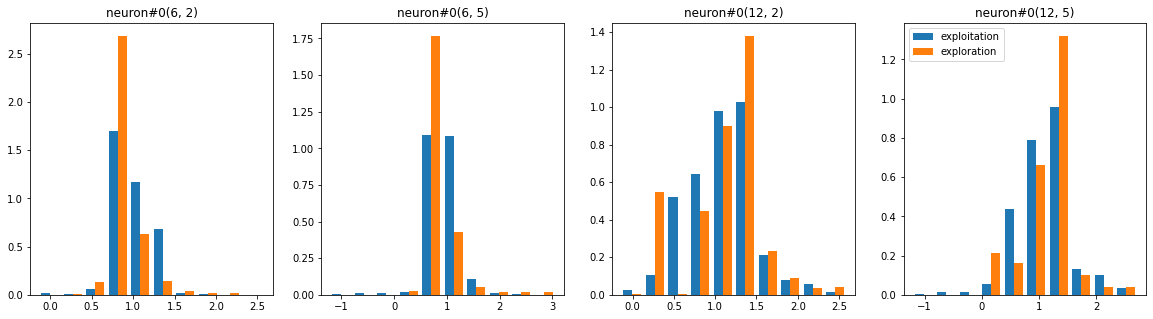

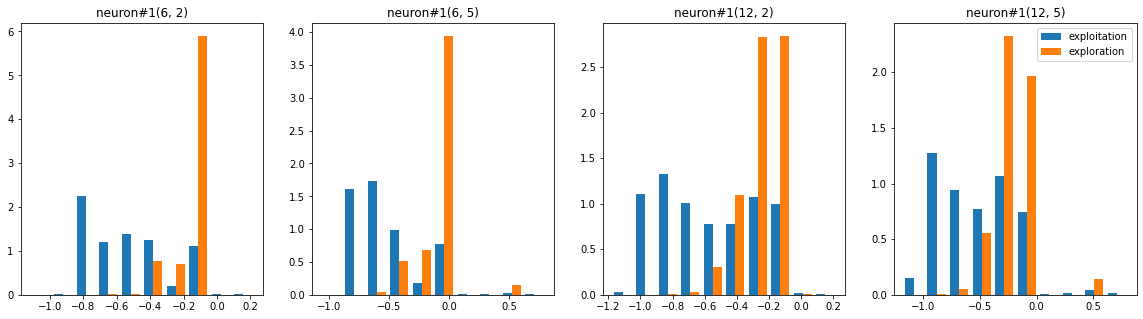

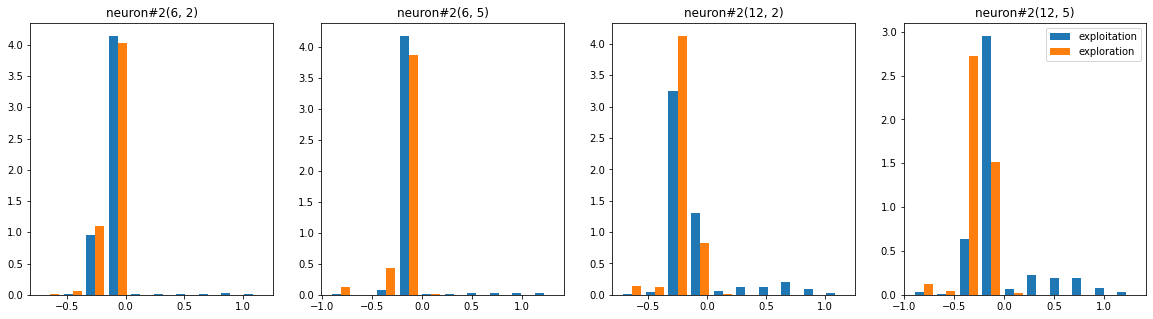

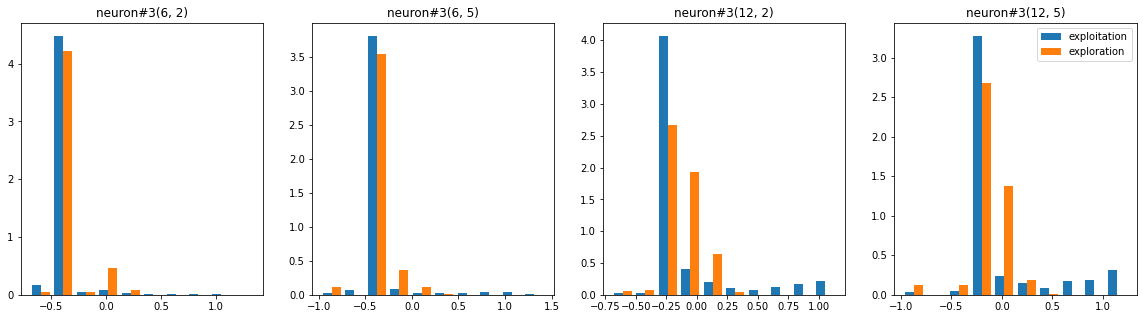

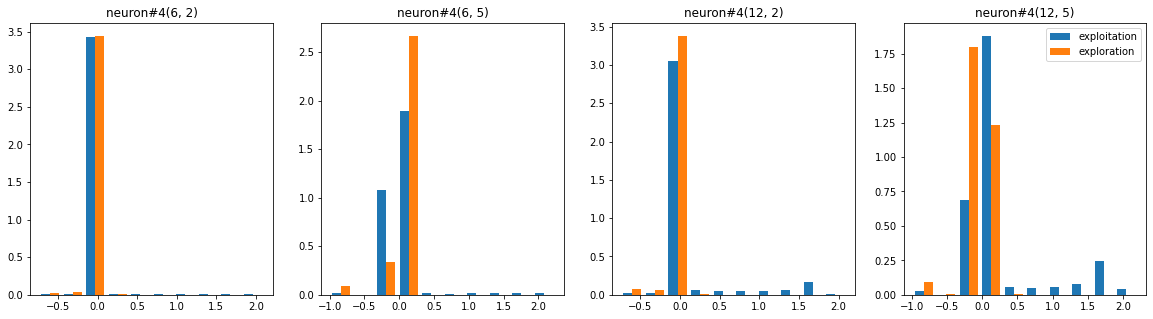

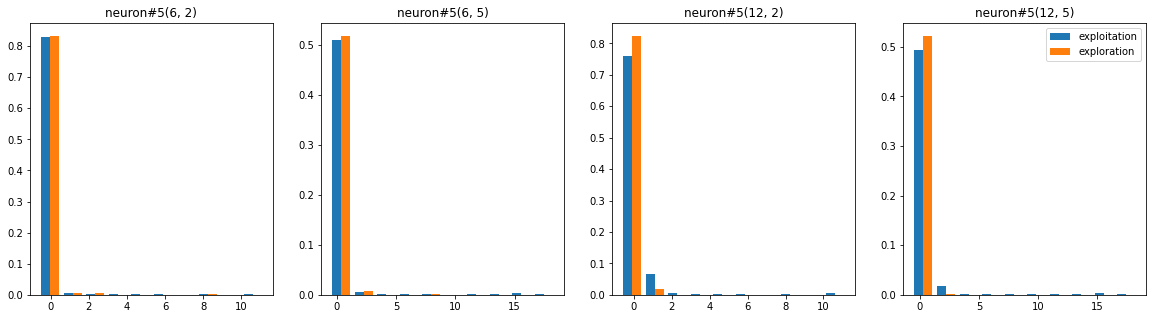

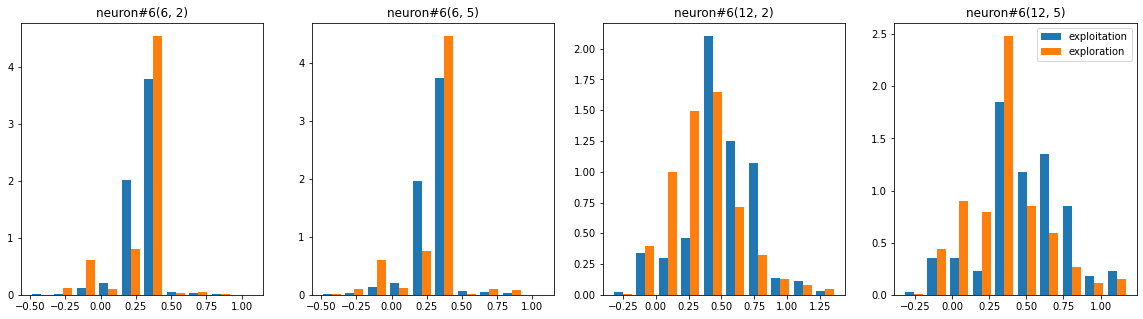

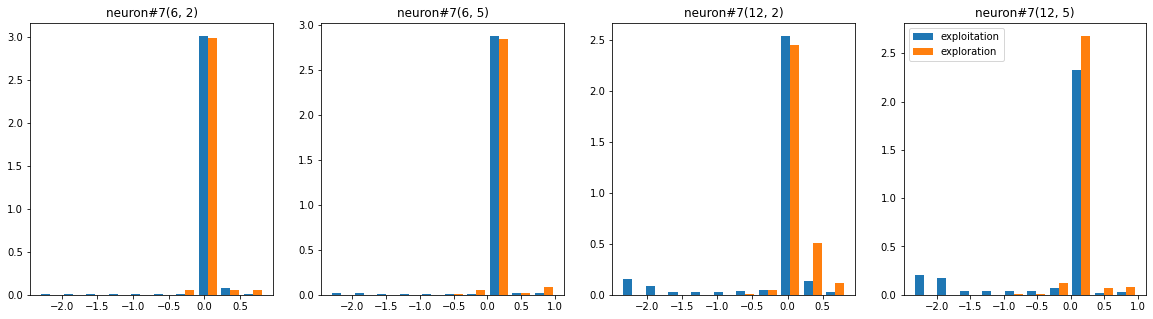

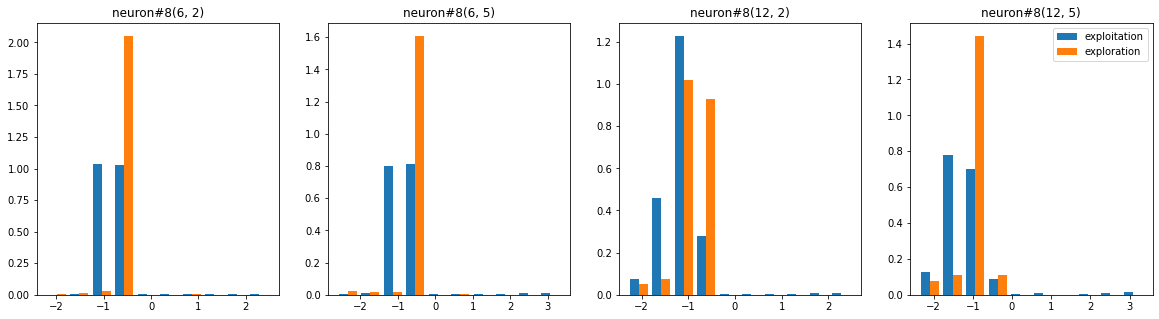

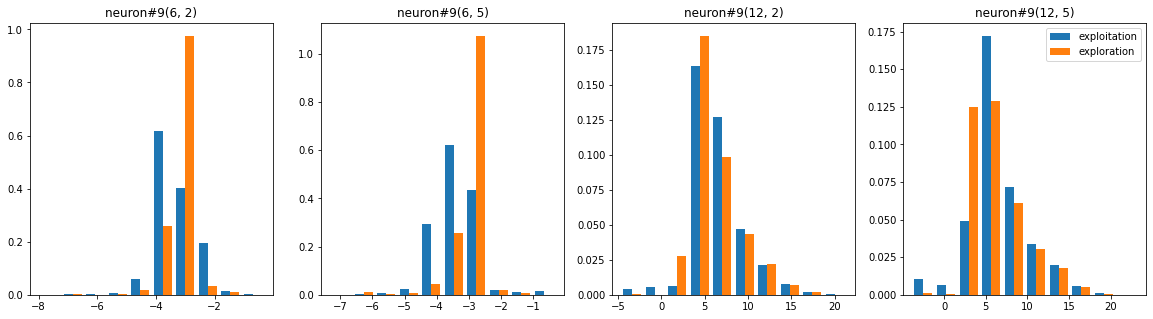

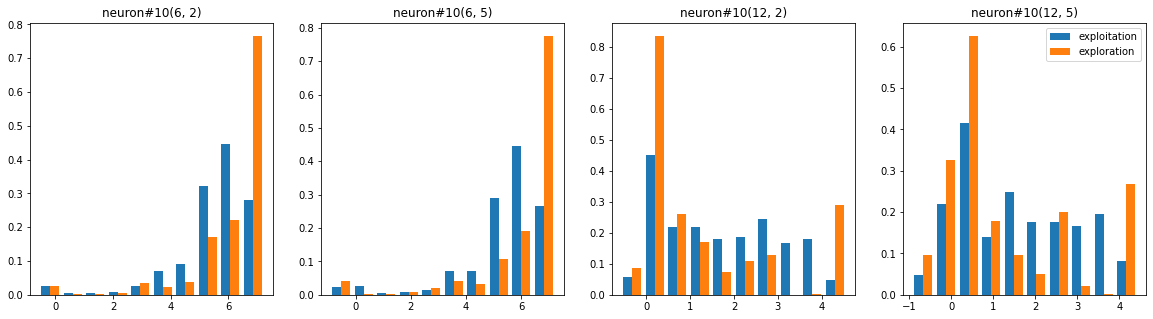

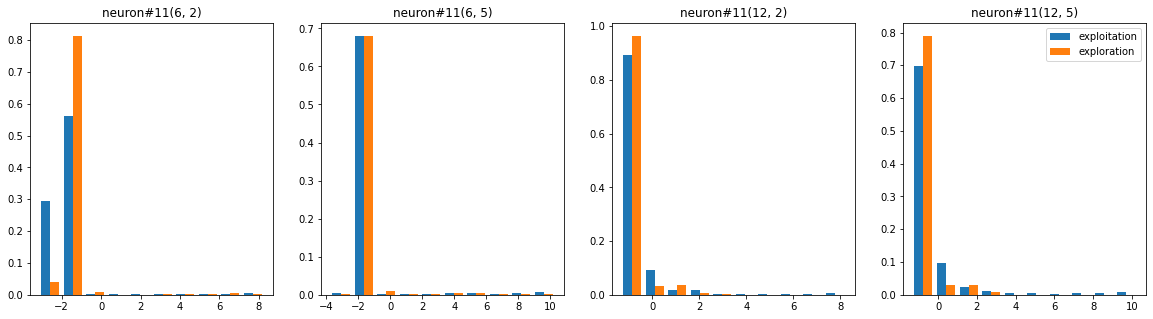

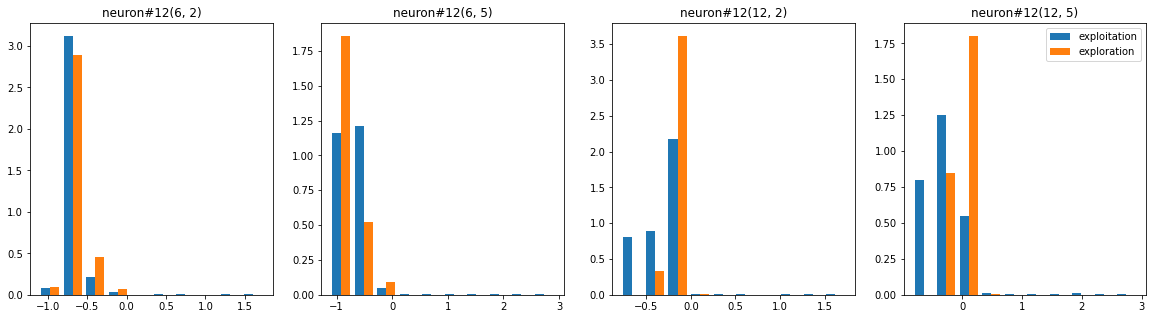

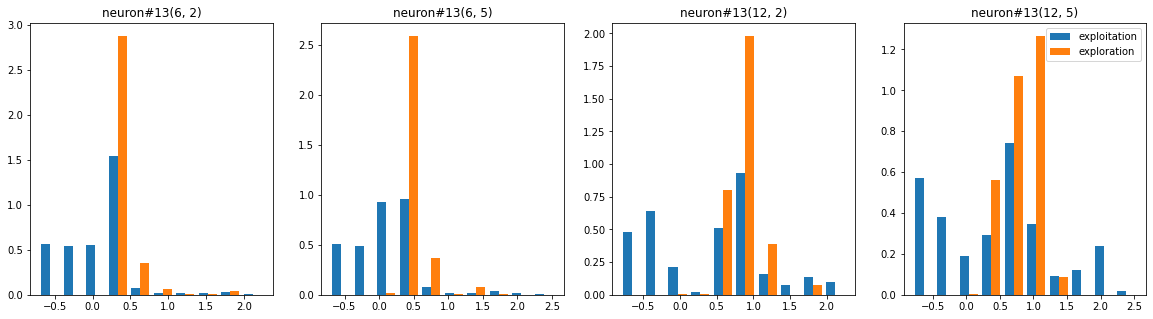

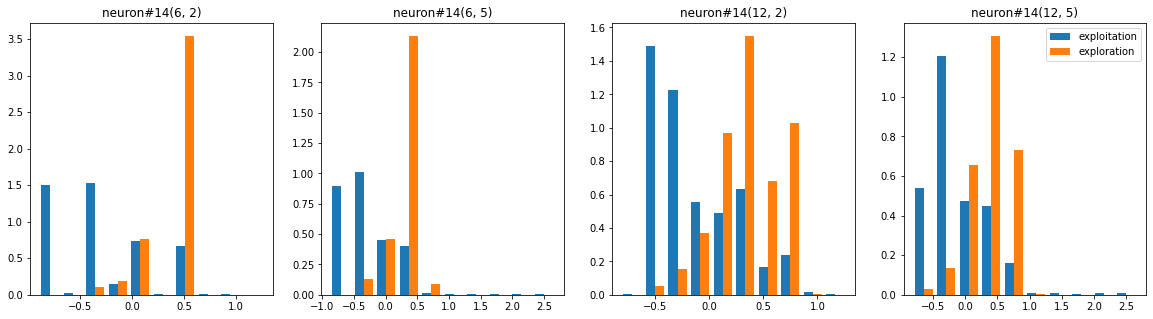

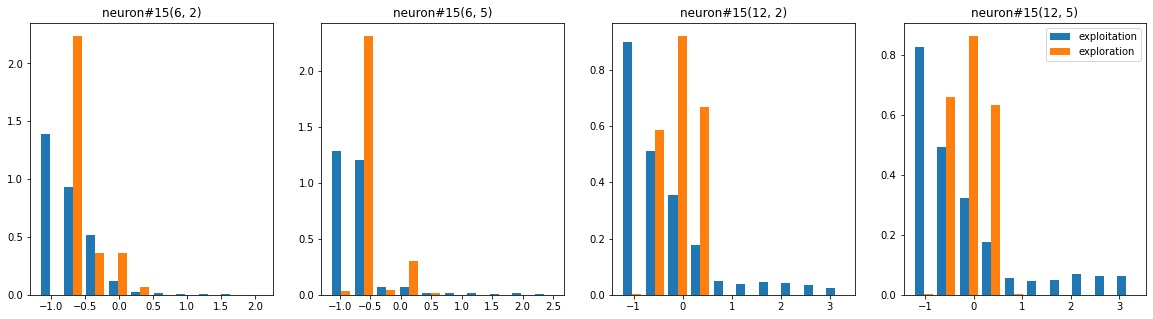

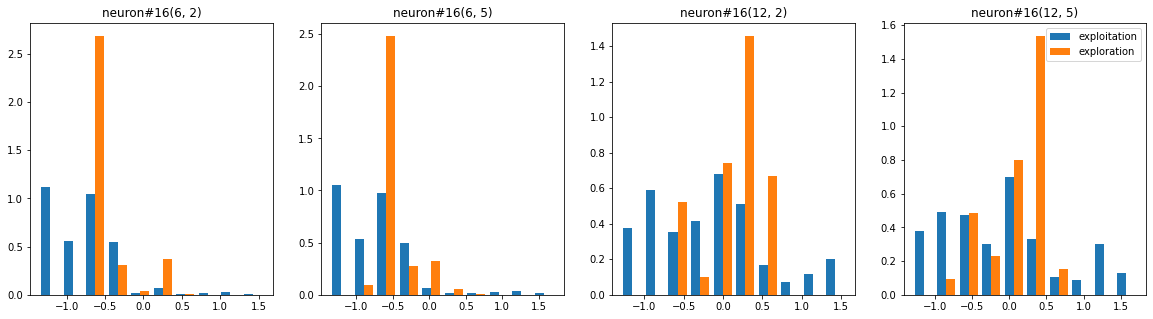

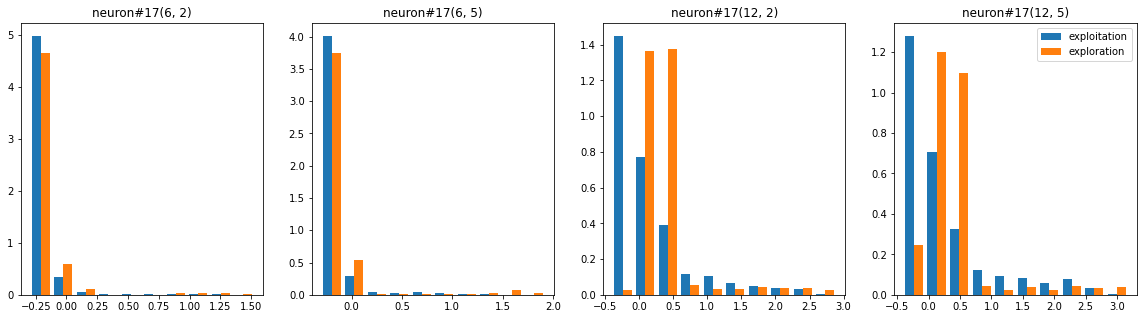

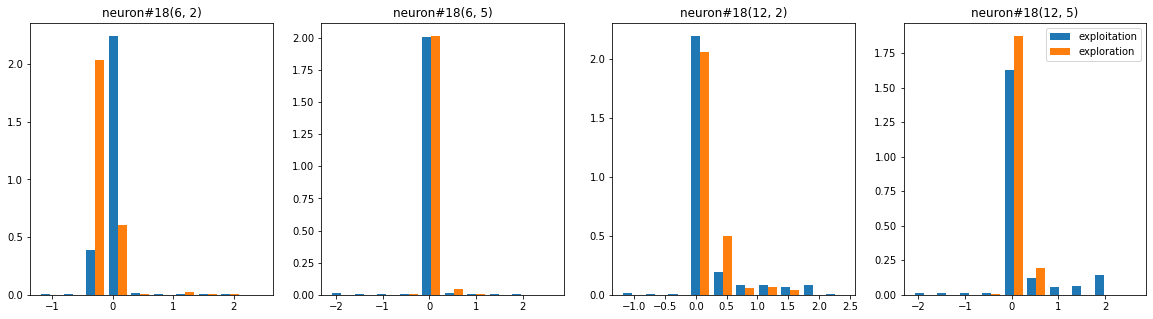

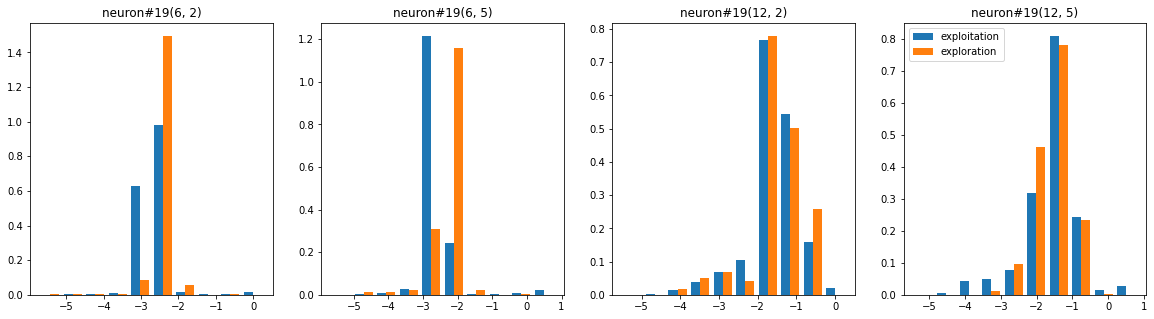

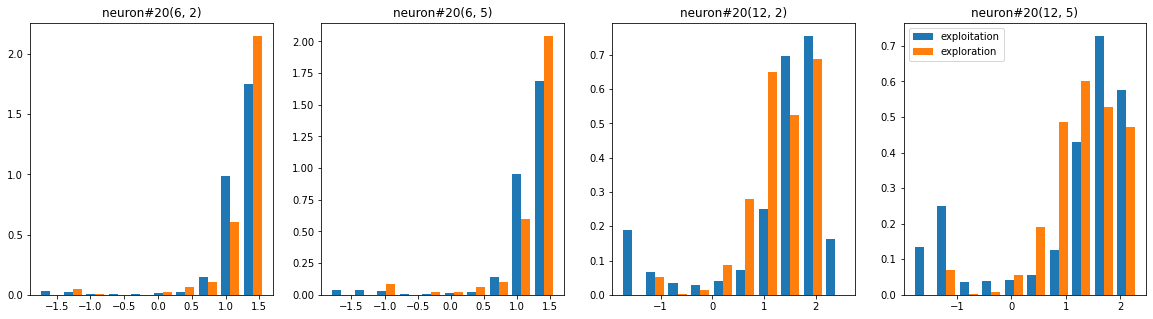

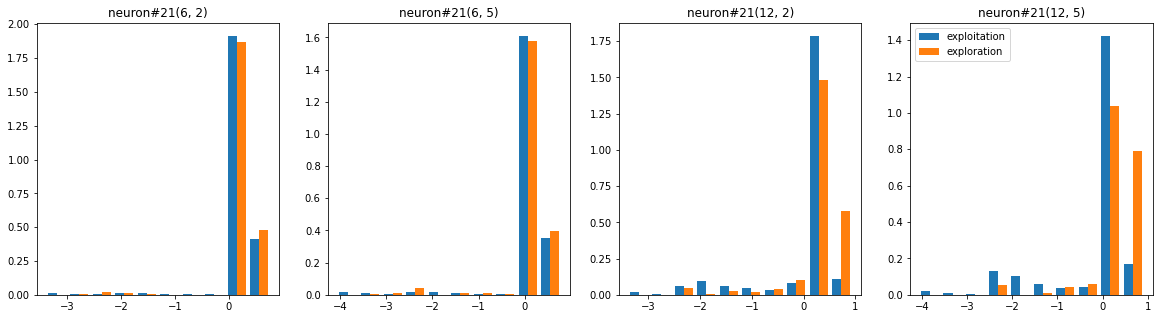

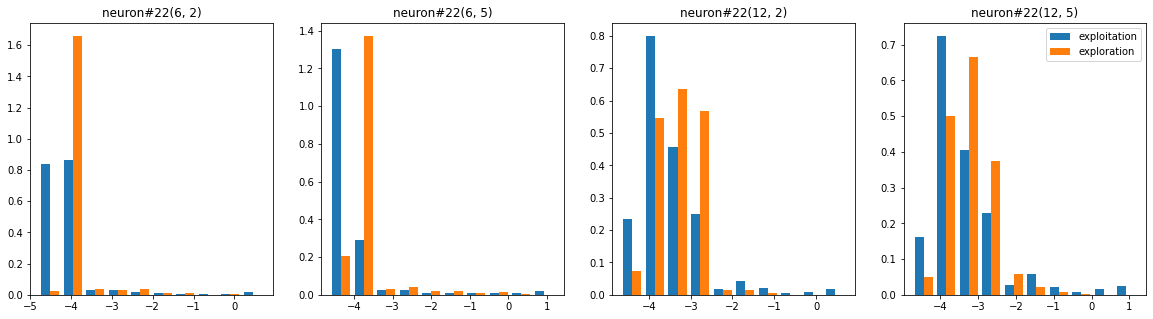

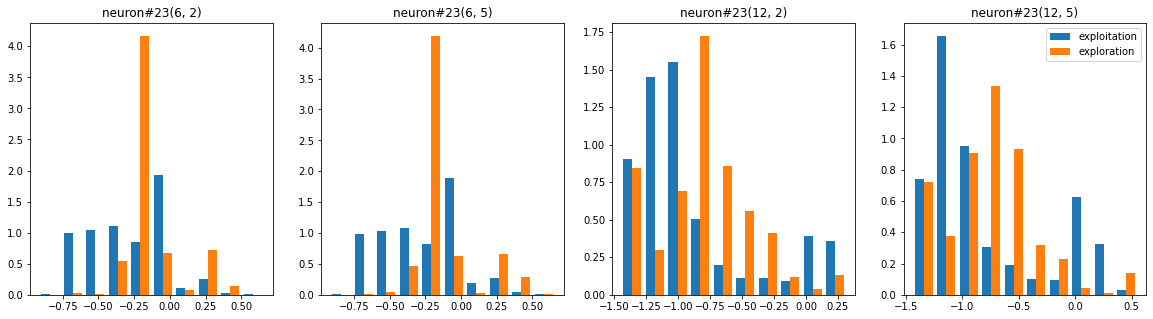

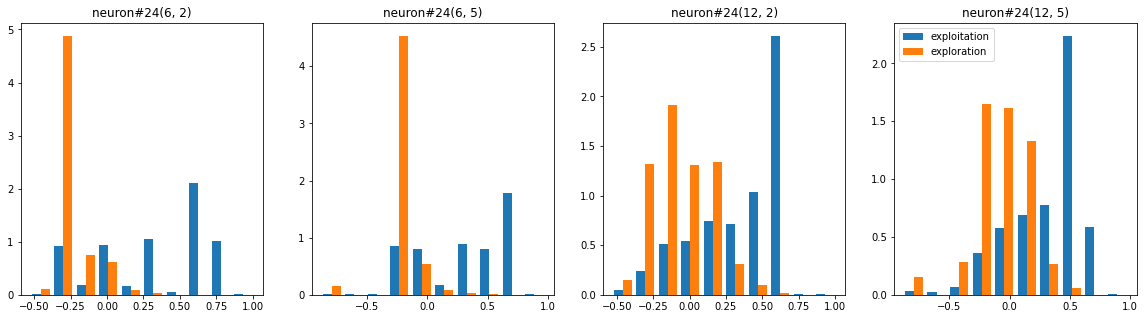

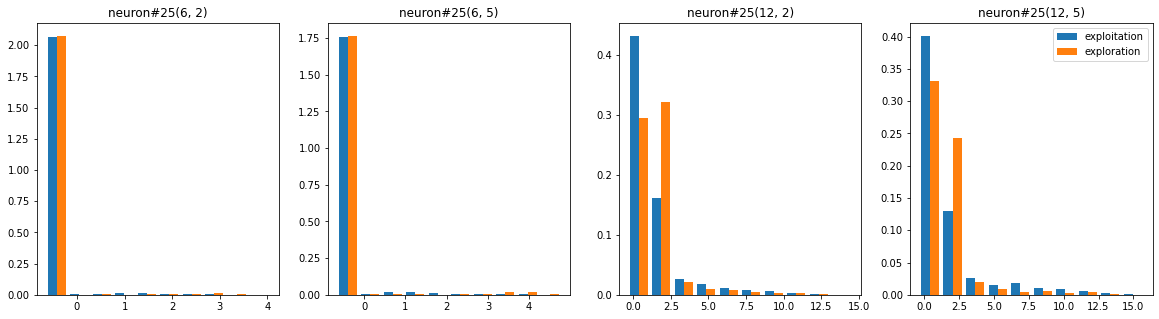

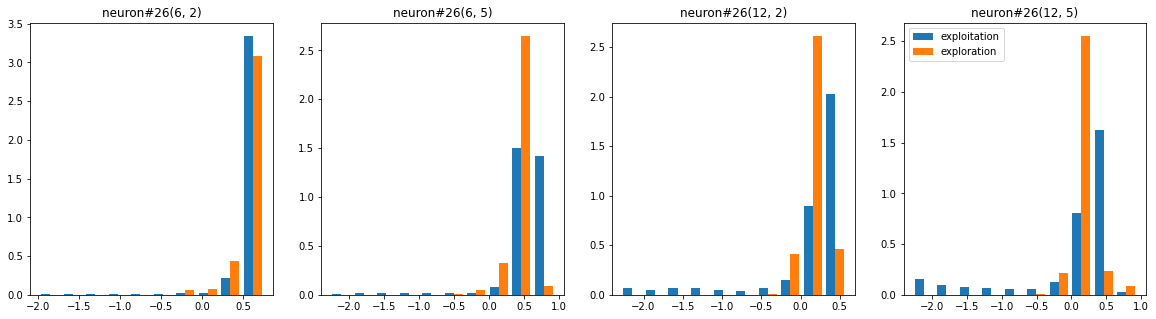

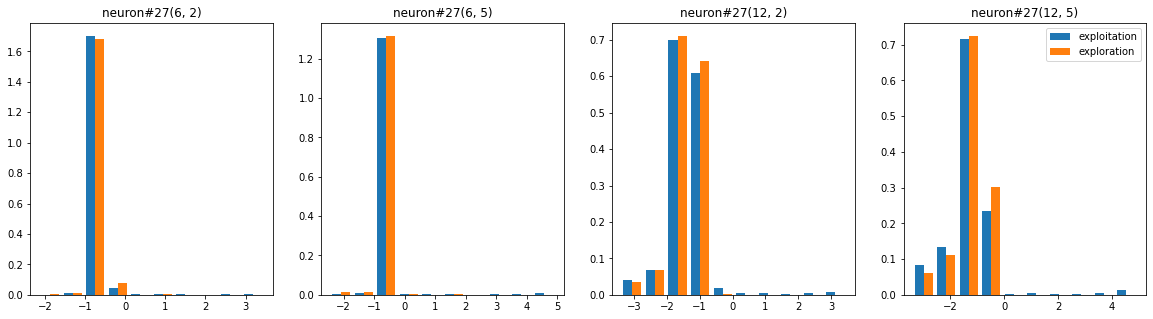

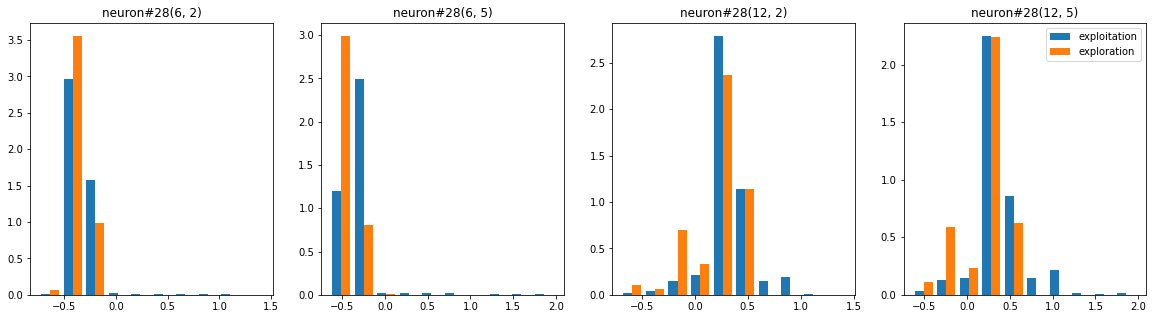

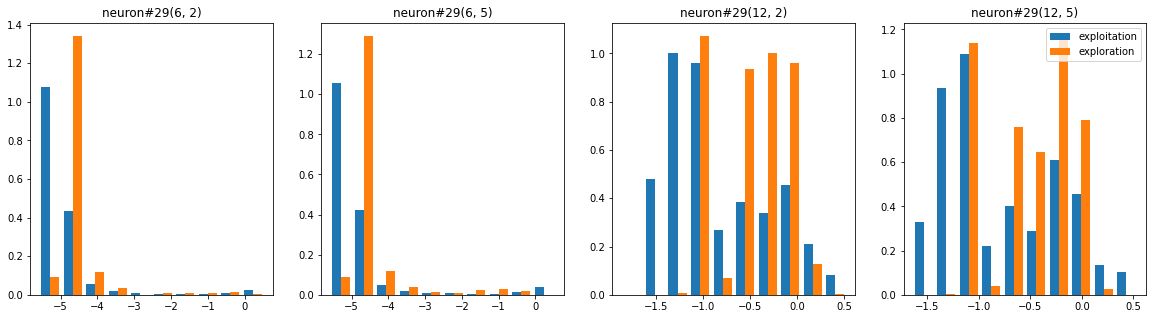

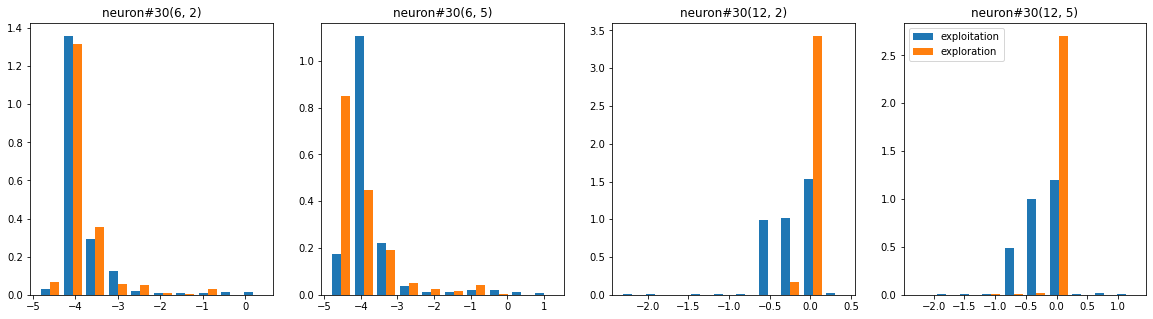

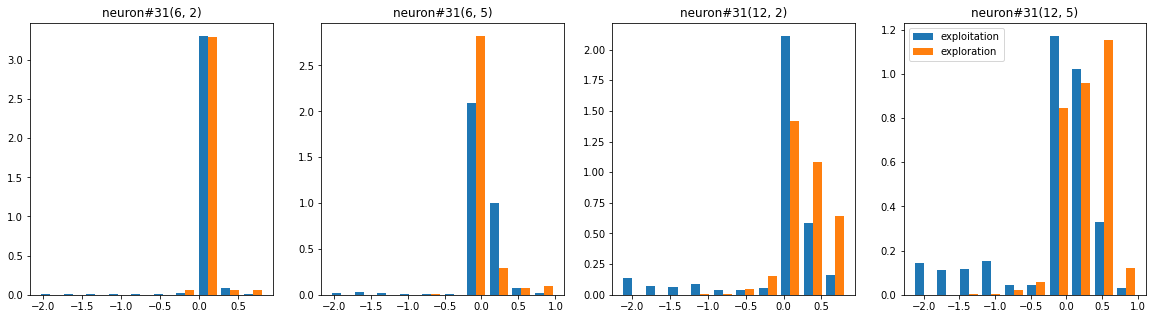

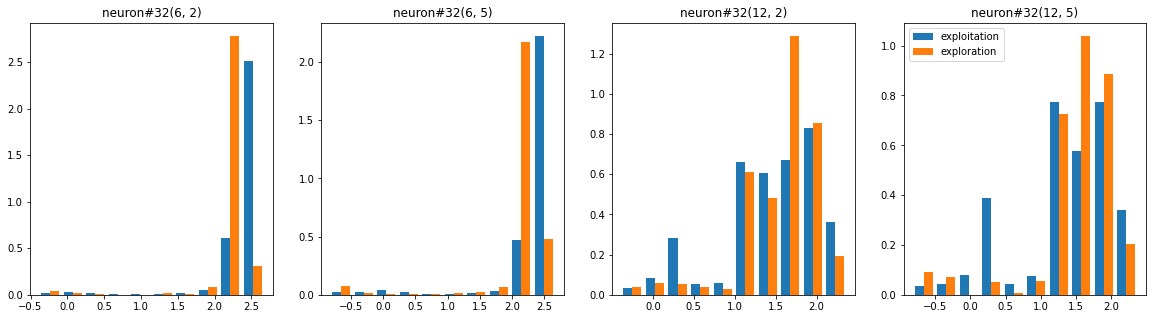

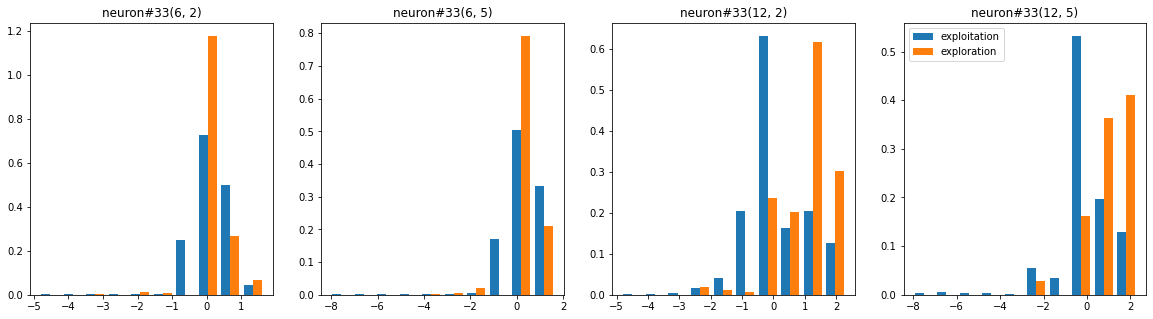

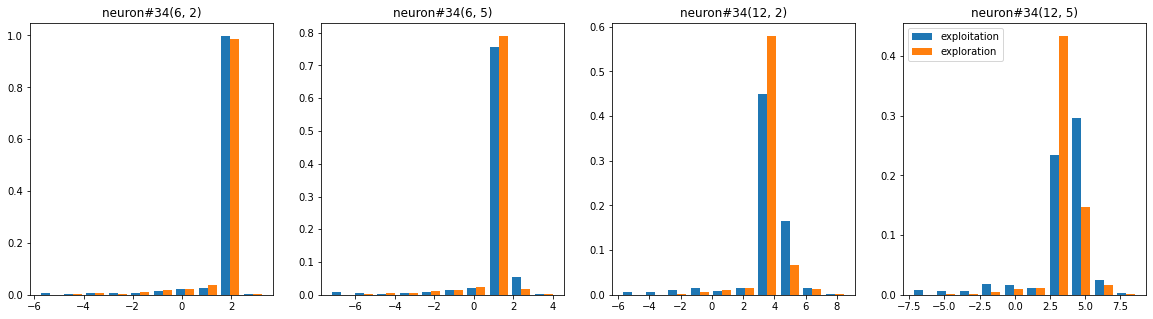

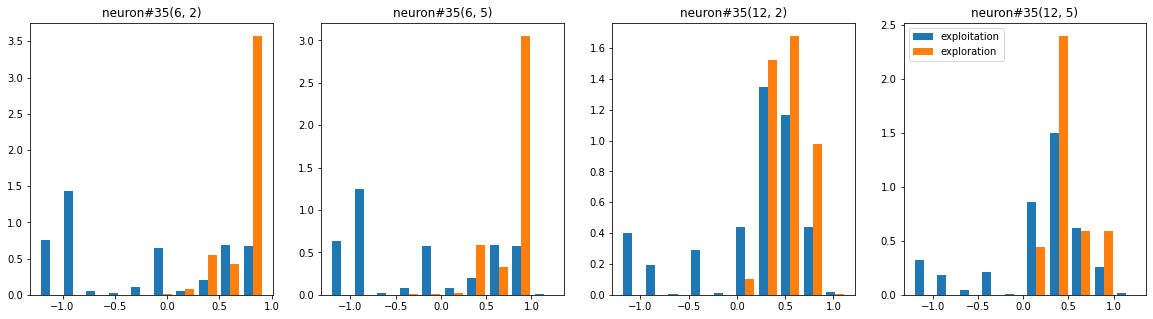

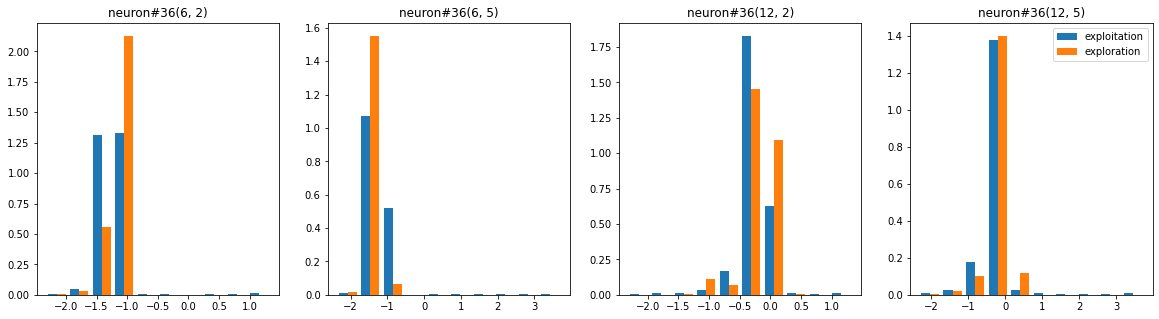

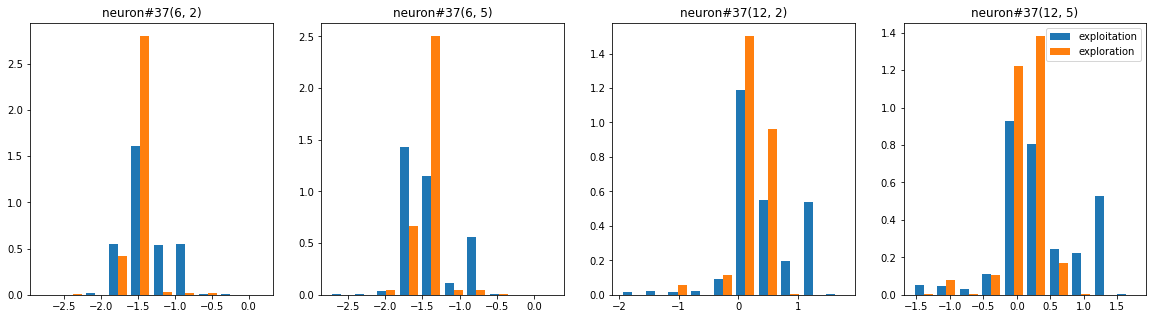

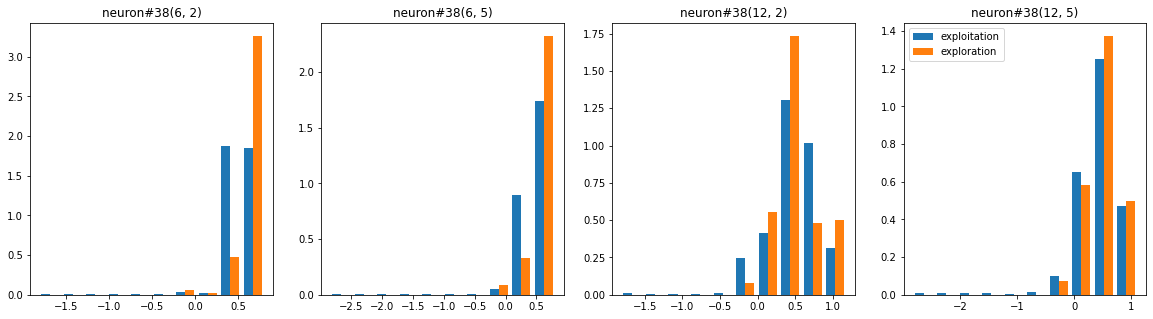

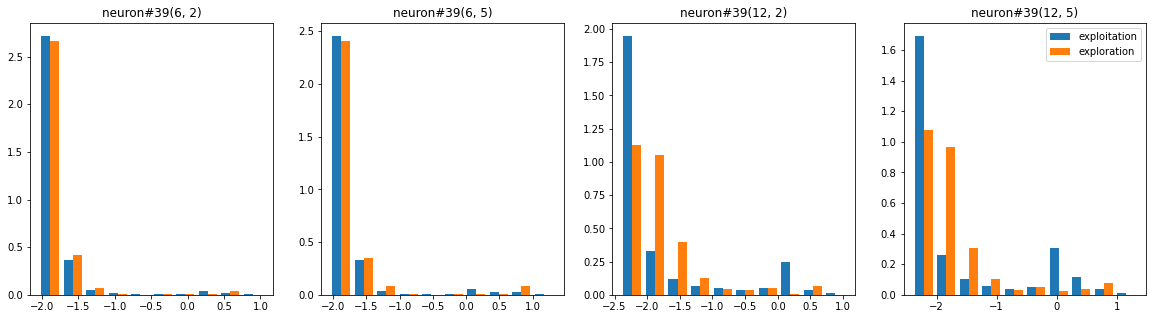

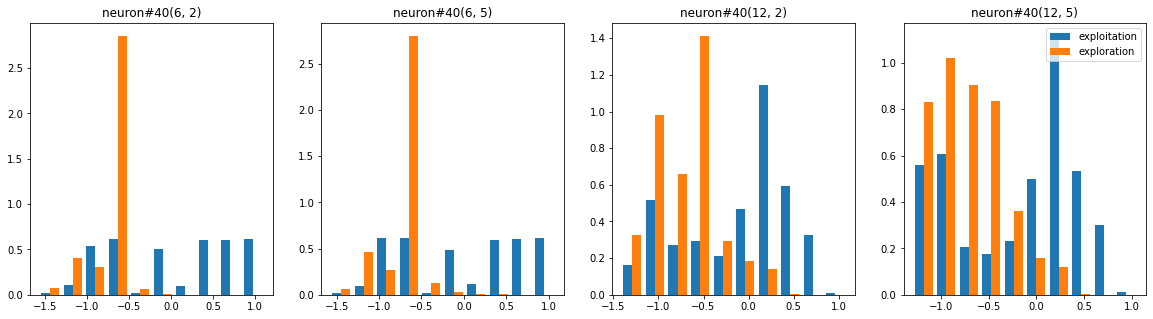

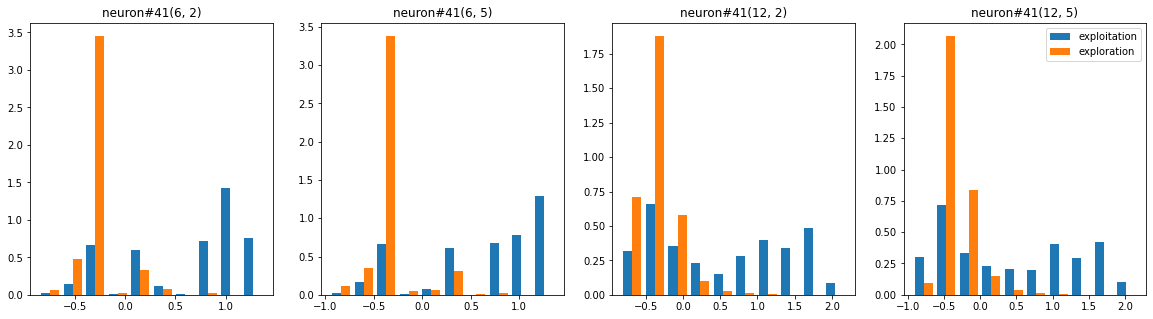

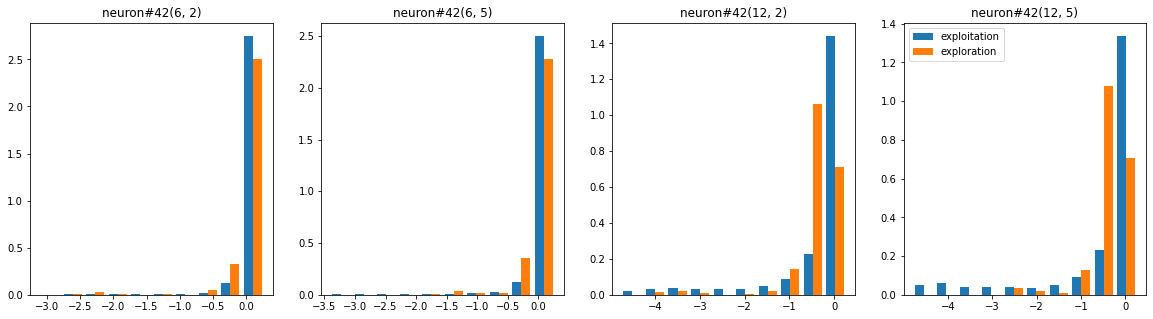

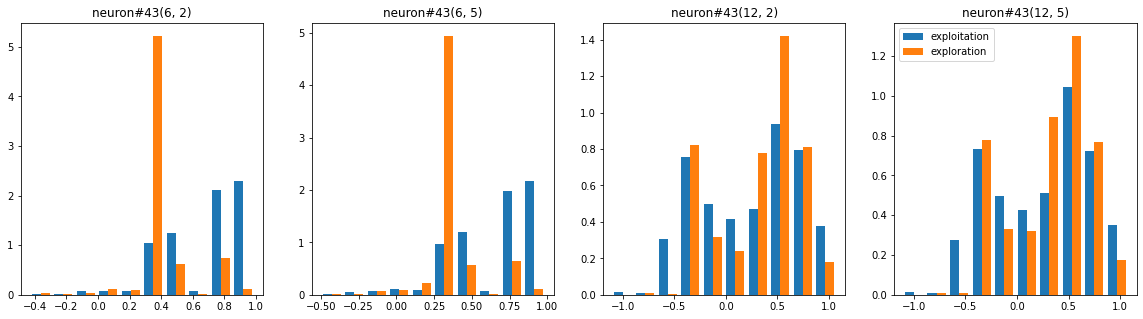

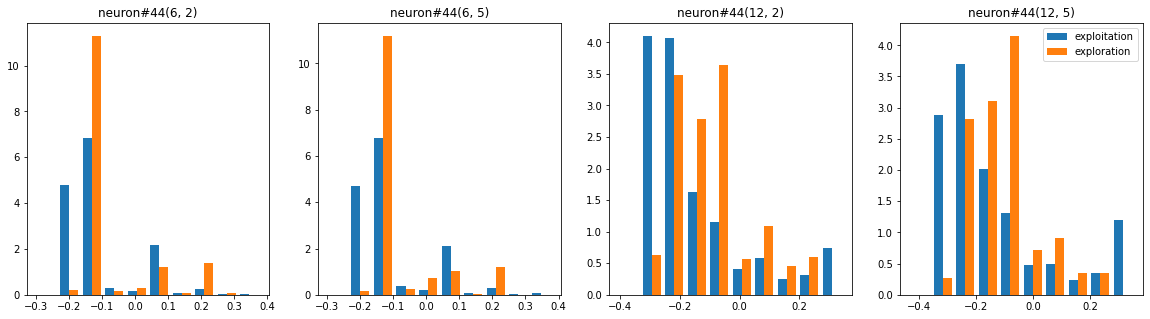

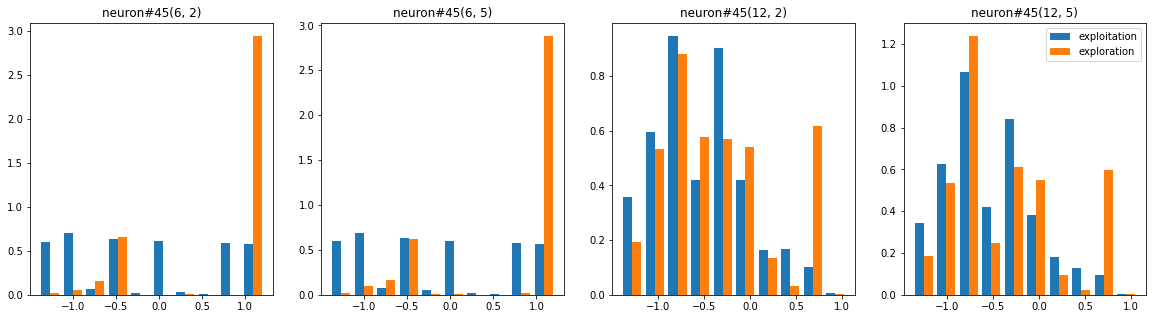

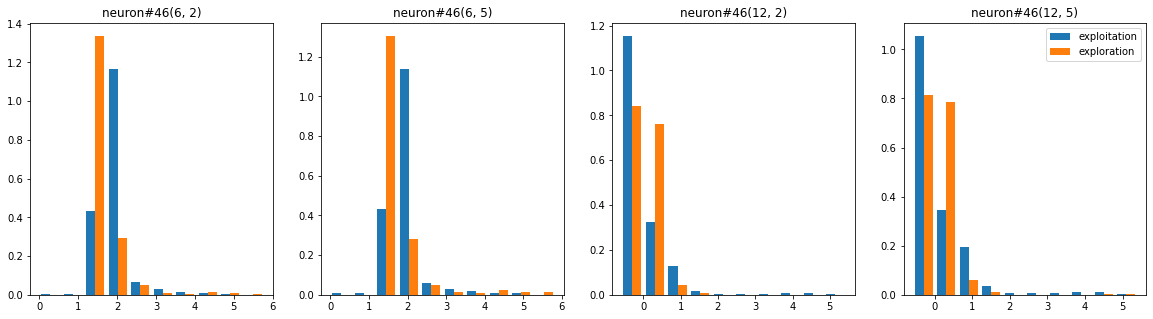

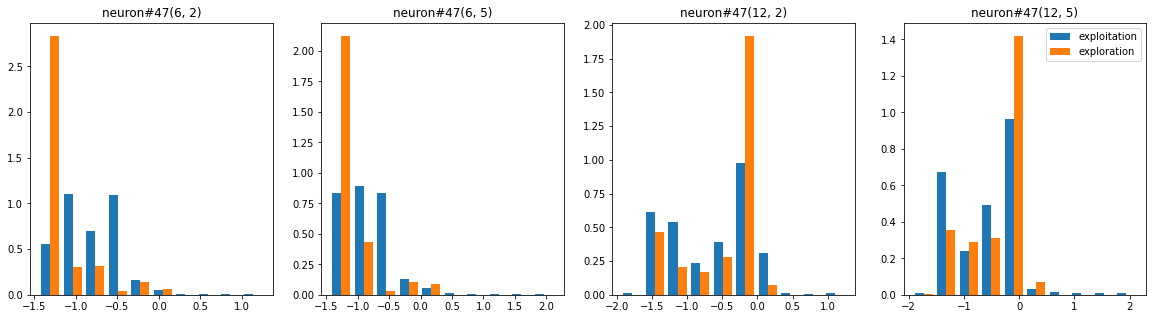

In [8]:
for idx in range(48):
    plt.figure(figsize=(20, 5))
    for i, key in enumerate(d.keys()):
        plt.subplot(1, 4, i+1)
        exploitation_activ = exploitation_activs[key]
        exploration_activ = exploration_activs[key]
        plt.hist((exploitation_activ[:, idx], exploration_activ[:, idx]), density=True)
        plt.title("neuron#"+str(idx)+(str(key)))
    plt.legend(['exploitation', 'exploration'])
    plt.show()

## Hypothesis: Maybe the current trial press count is based on the value solely? Or is there some neuron counting unrewarded presses?
## Unsurprisingly, value pred in FR trials remains same regardless of PR reward magnitude, but varies due to cost?

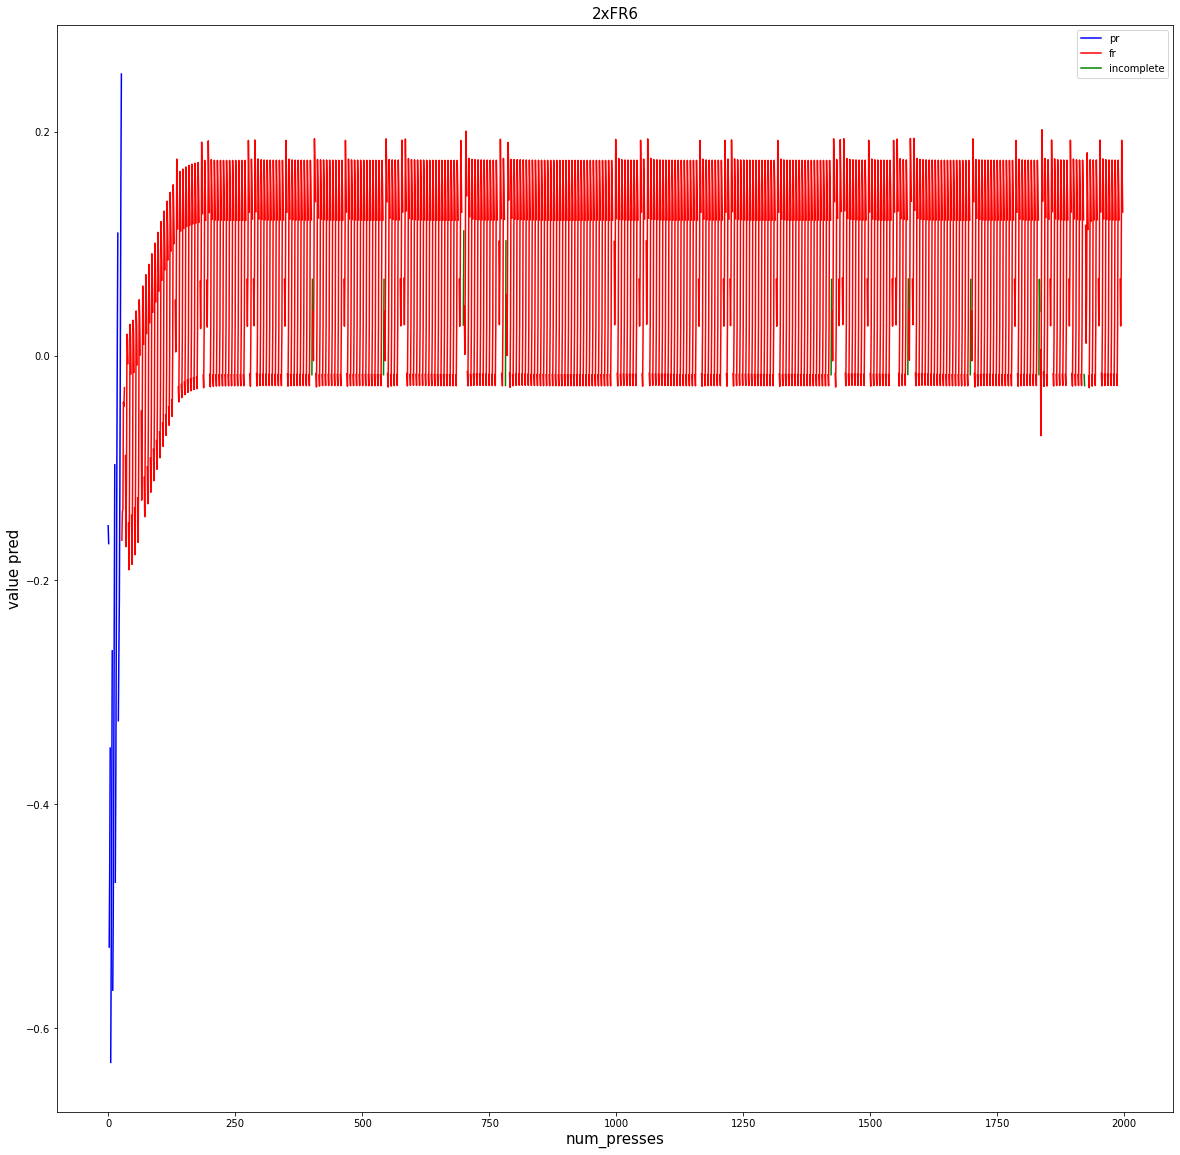

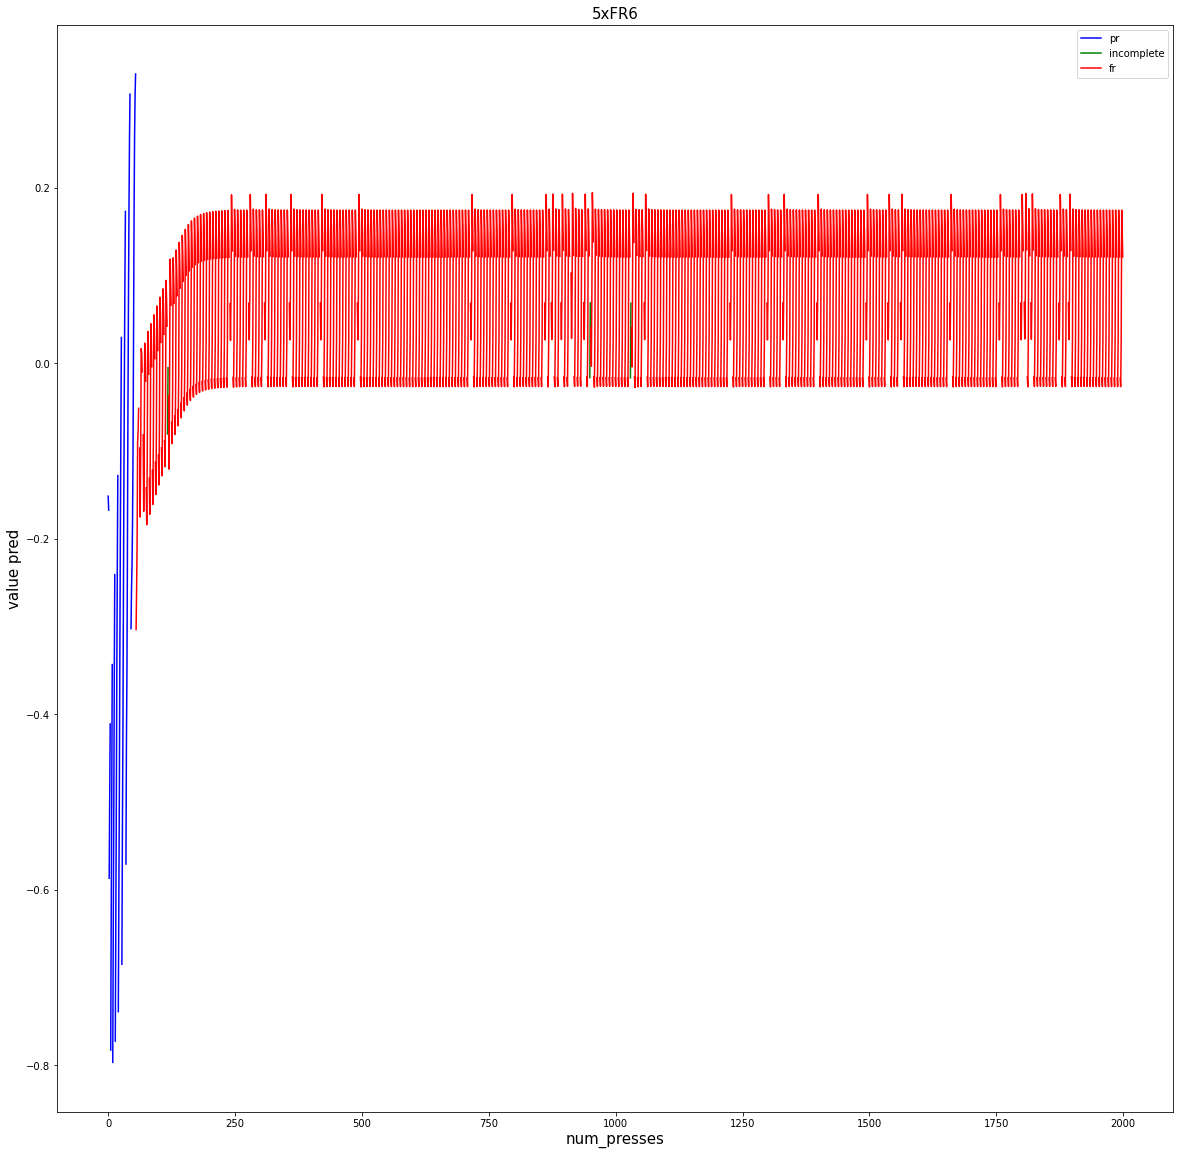

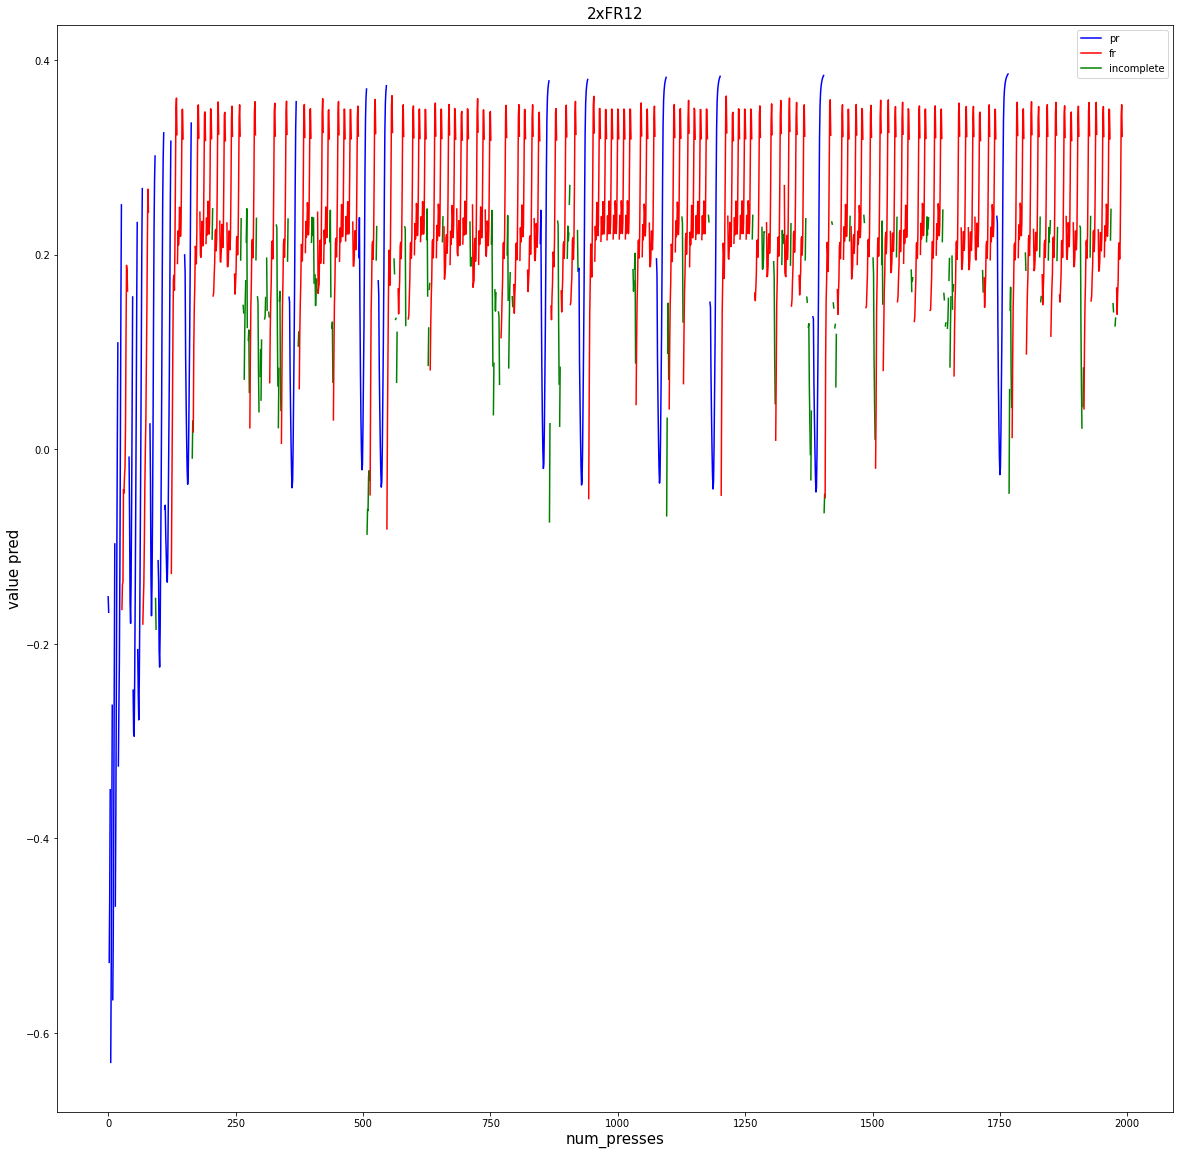

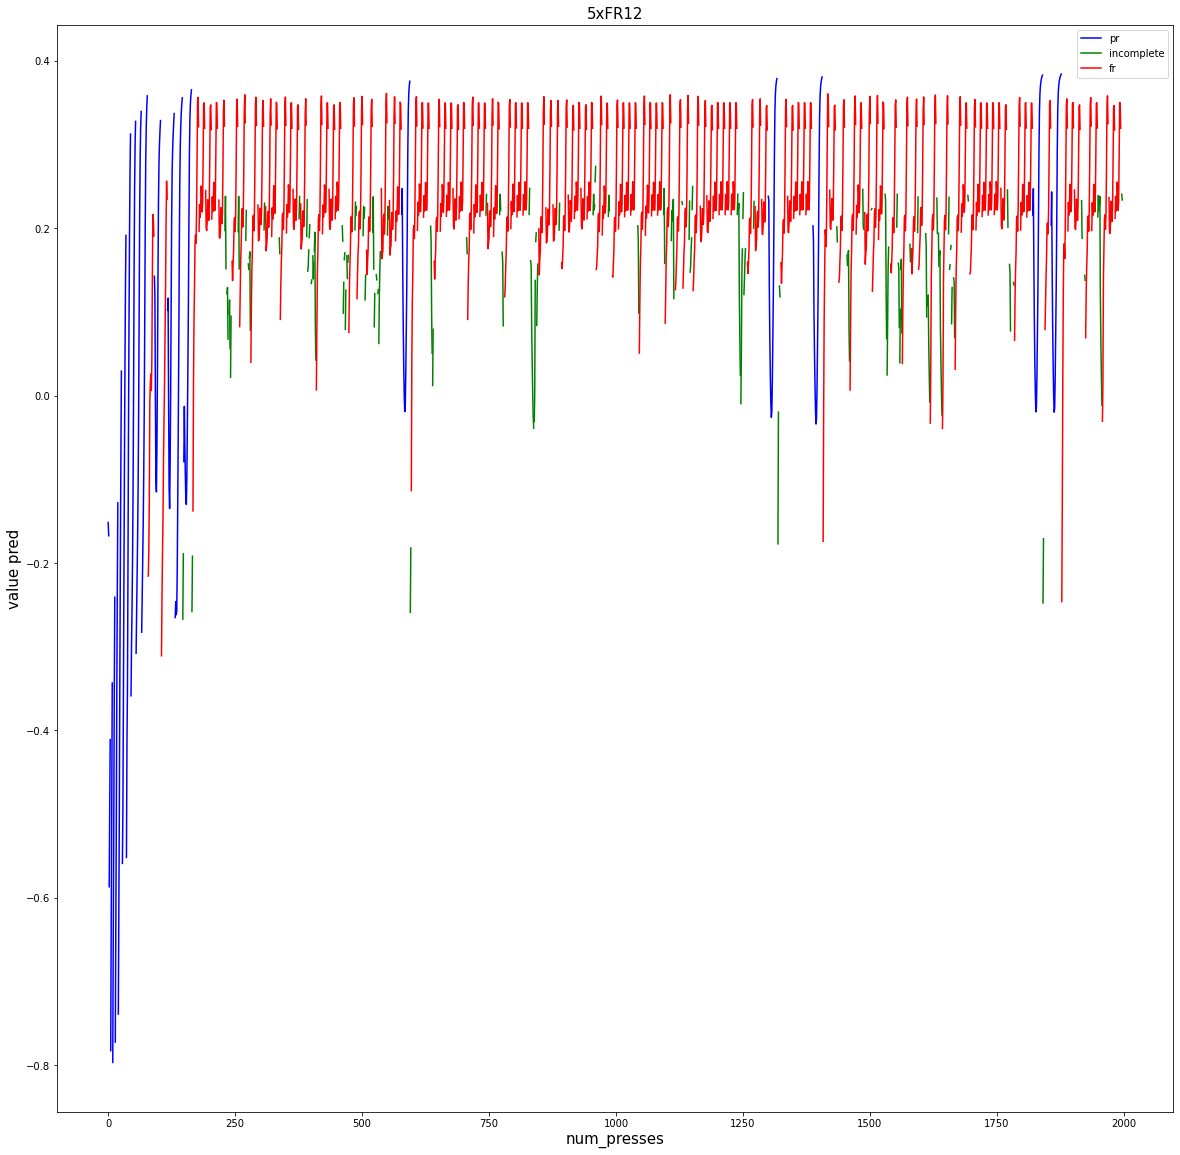

In [50]:
for (FR_limit, PR_reward), sessions in d.items(): # for each parameter setting
    for (actions, rewards, value_preds, activ_hist) in sessions: # for each session under a setting
        trials, trial_tags, trial_values = count_trials(actions, rewards, value_preds)
        exploration_values = ([trial_values[i] for i in range(len(trial_tags)) if trial_tags[i] == 2])
        exploitation_values = ([trial_values[i] for i in range(len(trial_tags)) if trial_tags[i] != 2])
#         plt.plot(np.concatenate(exploration_values), color = 'blue')
#         plt.plot(np.concatenate(exploitation_values), color = 'red')
    
    
        plt.figure(figsize = (20, 20))
        start = 0
        color = ['blue', 'red', 'green']
        label = ['pr', 'fr', 'incomplete']
        for i in range(len(trial_tags)):
            trial_value = trial_values[i]
            end = start + len(trial_value)
            plt.plot(np.arange(start, end), trial_value, color=color[trial_tags[i]], label=label[trial_tags[i]])
            label[trial_tags[i]] = "_nolegend_"
            start = end
        plt.xlabel('num_presses', fontsize=15)
        plt.ylabel('value pred', fontsize=15)
        plt.title('%dxFR%d'%(PR_reward, FR_limit), fontsize=15)
        plt.legend()
        break
